### Import necessary libraries:

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### A Convolutional Variational Autoencoder (VAE) with encoder-decoder architecture.

In [7]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(256)

        self.conv_mu = nn.Linear(256 * 2 * 2, latent_dim)
        self.conv_logvar = nn.Linear(256 * 2 * 2, latent_dim)
        self.z = nn.Linear(latent_dim, 256 * 2 * 2)
        
        # Decoder
        self.deconv1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.debatch_norm1 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.debatch_norm2 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.debatch_norm3 = nn.BatchNorm2d(32)
        self.deconv4 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)

        self.leaky_relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.leaky_relu(self.batch_norm1(self.conv1(x)))
        x = self.leaky_relu(self.batch_norm2(self.conv2(x)))
        x = self.leaky_relu(self.batch_norm3(self.conv3(x)))
        x = self.leaky_relu(self.batch_norm4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.z(z)
        x = x.view(-1, 256, 2, 2)
        x = self.leaky_relu(self.debatch_norm1(self.deconv1(x)))
        x = self.leaky_relu(self.debatch_norm2(self.deconv2(x)))
        x = self.leaky_relu(self.debatch_norm3(self.deconv3(x)))
        x = self.tanh(self.deconv4(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


### A Fully Connected Variational Autoencoder (VAE) with fully connected layers.

In [8]:
class FCVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(FCVAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)

        self.fc_mu = nn.Linear(hidden_dim * 4, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim * 4, latent_dim)

        # Latent to hidden
        self.z_fc = nn.Linear(latent_dim, hidden_dim * 4)

        # Decoder
        self.fc4 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc5 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, input_dim)

        # Weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def encode(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        h1 = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        h2 = F.leaky_relu(self.fc2(h1), negative_slope=0.2)
        h3 = F.leaky_relu(self.fc3(h2), negative_slope=0.2)
        mu = self.fc_mu(h3)
        logvar = self.fc_logvar(h3)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.leaky_relu(self.z_fc(z), negative_slope=0.2)
        h = F.leaky_relu(self.fc4(h), negative_slope=0.2)
        h = F.leaky_relu(self.fc5(h), negative_slope=0.2)
        x_recon = torch.tanh(self.fc6(h))  
        return x_recon.view(-1, 3072)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


### Loss function

In [9]:
def loss_function_cvae(recon_x, x, mu, logvar, beta=1):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD, MSE, KLD

def loss_function_fcvae(recon_x, x, mu, logvar, beta=1):
    MSE = nn.functional.mse_loss(recon_x, x.view(-1, 3072), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD, MSE, KLD

### Training the VAE

In [10]:
num_epochs = 15
lr = 0.0001
def train(model, train_loader, optimizer, epoch, num_epochs, model_name, device):
    model.train()
    train_loss_total = 0
    recon_loss_total = 0
    kld_loss_total = 0
    with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}', colour='green') as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            if model_name == 'cvae':
                data = data.view(data.size(0), 3, 32, 32).to(device)
            elif model_name == 'fcvae':
                data = data.view(data.size(0), -1).to(device)   
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            if model_name == 'cvae':
                loss_function = loss_function_cvae
            elif model_name == 'fcvae':
                loss_function = loss_function_fcvae
            total_loss, recon_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
            total_loss.backward()
            train_loss_total += total_loss.item()
            recon_loss_total += recon_loss.item()
            kld_loss_total += kld_loss.item()
            optimizer.step()
            tepoch.set_postfix(
                train_loss=train_loss_total / len(train_loader.dataset),
                recon_loss=recon_loss_total / len(train_loader.dataset),
                kld_loss=kld_loss_total / len(train_loader.dataset)
            )
    print(f'Epoch {epoch}/{num_epochs} train loss: {train_loss_total / len(train_loader.dataset)} mse loss: {recon_loss_total / len(train_loader.dataset)} kld loss: {kld_loss_total / len(train_loader.dataset)}')

### Train the Models

#### Train the Convolutional VAE

In [11]:
transform_cvae = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset_cvae = datasets.CIFAR10('./data/cvae', train=True, download=True, transform=transform_cvae)
train_loader_cvae = torch.utils.data.DataLoader(train_dataset_cvae, batch_size=64, shuffle=True)

cvae = ConvVAE(latent_dim=128).to(device)
optimizer_cvae = optim.Adam(cvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(cvae, train_loader_cvae, optimizer_cvae, epoch, num_epochs, 'cvae', device)

Files already downloaded and verified


Epoch 1: 100%|██████████| 782/782 [00:19<00:00, 40.04batch/s, kld_loss=37.8, recon_loss=402, train_loss=440]  


Epoch 1/15 train loss: 440.0476364160156 mse loss: 402.2925683203125 kld loss: 37.75506885009766


Epoch 2: 100%|██████████| 782/782 [00:19<00:00, 40.85batch/s, kld_loss=44.8, recon_loss=229, train_loss=274]  


Epoch 2/15 train loss: 273.71117904296875 mse loss: 228.94382533203125 kld loss: 44.76735388427734


Epoch 3: 100%|██████████| 782/782 [00:18<00:00, 41.59batch/s, kld_loss=46, recon_loss=199, train_loss=245]     


Epoch 3/15 train loss: 244.75730181640625 mse loss: 198.72137239746093 kld loss: 46.03592940917969


Epoch 4: 100%|██████████| 782/782 [00:19<00:00, 40.00batch/s, kld_loss=47.3, recon_loss=185, train_loss=232]  


Epoch 4/15 train loss: 232.2223140966797 mse loss: 184.9011425 kld loss: 47.321171801757814


Epoch 5: 100%|██████████| 782/782 [00:18<00:00, 41.98batch/s, kld_loss=48.7, recon_loss=176, train_loss=225]  


Epoch 5/15 train loss: 224.5668234765625 mse loss: 175.8554137158203 kld loss: 48.711409924316406


Epoch 6: 100%|██████████| 782/782 [00:18<00:00, 41.67batch/s, kld_loss=50, recon_loss=169, train_loss=219]    


Epoch 6/15 train loss: 219.34199224609375 mse loss: 169.30834686523437 kld loss: 50.033644995117186


Epoch 7: 100%|██████████| 782/782 [00:18<00:00, 41.94batch/s, kld_loss=51.3, recon_loss=163, train_loss=214]  


Epoch 7/15 train loss: 214.42618590820314 mse loss: 163.0853531640625 kld loss: 51.34083279785156


Epoch 8: 100%|██████████| 782/782 [00:18<00:00, 41.36batch/s, kld_loss=52.4, recon_loss=158, train_loss=211]  


Epoch 8/15 train loss: 210.73681663085938 mse loss: 158.3263815673828 kld loss: 52.41043517944336


Epoch 9: 100%|██████████| 782/782 [00:19<00:00, 40.95batch/s, kld_loss=53.2, recon_loss=155, train_loss=209]  


Epoch 9/15 train loss: 208.543277890625 mse loss: 155.29515758789063 kld loss: 53.248120529785155


Epoch 10: 100%|██████████| 782/782 [00:18<00:00, 42.31batch/s, kld_loss=53.9, recon_loss=152, train_loss=206]   


Epoch 10/15 train loss: 206.375958515625 mse loss: 152.4477159765625 kld loss: 53.928242561035155


Epoch 11: 100%|██████████| 782/782 [00:17<00:00, 43.61batch/s, kld_loss=54.5, recon_loss=150, train_loss=205]  


Epoch 11/15 train loss: 204.5103400048828 mse loss: 150.05357795898436 kld loss: 54.456762010498046


Epoch 12: 100%|██████████| 782/782 [00:18<00:00, 42.15batch/s, kld_loss=54.9, recon_loss=148, train_loss=203]   


Epoch 12/15 train loss: 203.12291541015625 mse loss: 148.2213820605469 kld loss: 54.901532966308594


Epoch 13: 100%|██████████| 782/782 [00:18<00:00, 42.74batch/s, kld_loss=55.4, recon_loss=146, train_loss=202]   


Epoch 13/15 train loss: 201.596325 mse loss: 146.21117740234374 kld loss: 55.385147502441406


Epoch 14: 100%|██████████| 782/782 [00:18<00:00, 41.38batch/s, kld_loss=55.7, recon_loss=145, train_loss=201]   


Epoch 14/15 train loss: 200.77730677734374 mse loss: 145.0684485546875 kld loss: 55.708857980957035


Epoch 15: 100%|██████████| 782/782 [00:33<00:00, 23.30batch/s, kld_loss=56, recon_loss=144, train_loss=200]    

Epoch 15/15 train loss: 199.61716127929688 mse loss: 143.6020994140625 kld loss: 56.015061911621096


#### Train the Fully Connected VAE

In [12]:
transform_fcvae = transforms.Compose([
    transforms.ToTensor()
])

train_dataset_fcvae = datasets.CIFAR10('./data/fcvae', train=True, download=True, transform=transform_fcvae)
train_loader_fcvae = torch.utils.data.DataLoader(train_dataset_fcvae, batch_size=64, shuffle=True)

fcvae = FCVAE(input_dim=3072, hidden_dim=1000, latent_dim=128).to(device)
optimizer_fcvae = optim.Adam(fcvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(fcvae, train_loader_fcvae, optimizer_fcvae, epoch, num_epochs, 'fcvae', device)

Files already downloaded and verified


Epoch 1: 100%|██████████| 782/782 [00:16<00:00, 46.24batch/s, kld_loss=11, recon_loss=128, train_loss=139]    


Epoch 1/15 train loss: 138.53721385009766 mse loss: 127.50393132324218 kld loss: 11.033282455444336


Epoch 2: 100%|██████████| 782/782 [00:11<00:00, 65.27batch/s, kld_loss=11.9, recon_loss=88.9, train_loss=101]   


Epoch 2/15 train loss: 100.7926865209961 mse loss: 88.92768897949219 kld loss: 11.86499754699707


Epoch 3: 100%|██████████| 782/782 [00:17<00:00, 45.08batch/s, kld_loss=12.7, recon_loss=81.5, train_loss=94.1]  


Epoch 3/15 train loss: 94.141124453125 mse loss: 81.4651024609375 kld loss: 12.676022014160155


Epoch 4: 100%|██████████| 782/782 [00:17<00:00, 45.14batch/s, kld_loss=13.1, recon_loss=77.7, train_loss=90.7]  


Epoch 4/15 train loss: 90.73944803710937 mse loss: 77.65781374511718 kld loss: 13.081634298095704


Epoch 5: 100%|██████████| 782/782 [00:12<00:00, 63.88batch/s, kld_loss=13.6, recon_loss=74.5, train_loss=88.1] 


Epoch 5/15 train loss: 88.10413199707031 mse loss: 74.45784859863281 kld loss: 13.646283334960938


Epoch 6: 100%|██████████| 782/782 [00:11<00:00, 68.16batch/s, kld_loss=14.2, recon_loss=72.1, train_loss=86.3]  


Epoch 6/15 train loss: 86.2997465209961 mse loss: 72.1220353125 kld loss: 14.177711137390137


Epoch 7: 100%|██████████| 782/782 [00:11<00:00, 69.78batch/s, kld_loss=14.6, recon_loss=70.7, train_loss=85.4] 


Epoch 7/15 train loss: 85.35173329589844 mse loss: 70.71897360839844 kld loss: 14.6327595993042


Epoch 8: 100%|██████████| 782/782 [00:11<00:00, 70.30batch/s, kld_loss=15.3, recon_loss=68.8, train_loss=84.1]  


Epoch 8/15 train loss: 84.1103053515625 mse loss: 68.8283840234375 kld loss: 15.28192118560791


Epoch 9: 100%|██████████| 782/782 [00:11<00:00, 66.28batch/s, kld_loss=16, recon_loss=67, train_loss=83]       


Epoch 9/15 train loss: 82.95161814697266 mse loss: 66.95994469970704 kld loss: 15.991673359985352


Epoch 10: 100%|██████████| 782/782 [00:11<00:00, 68.09batch/s, kld_loss=16.5, recon_loss=65.6, train_loss=82.1] 


Epoch 10/15 train loss: 82.08284856933594 mse loss: 65.63137373779297 kld loss: 16.451474852905275


Epoch 11: 100%|██████████| 782/782 [00:11<00:00, 69.20batch/s, kld_loss=17, recon_loss=64.3, train_loss=81.3]   


Epoch 11/15 train loss: 81.310093125 mse loss: 64.34770368652343 kld loss: 16.96238946044922


Epoch 12: 100%|██████████| 782/782 [00:11<00:00, 65.72batch/s, kld_loss=17.3, recon_loss=63.6, train_loss=80.8]  


Epoch 12/15 train loss: 80.82321424804688 mse loss: 63.554674921875 kld loss: 17.268539396972656


Epoch 13: 100%|██████████| 782/782 [00:11<00:00, 66.81batch/s, kld_loss=17.5, recon_loss=62.9, train_loss=80.3] 


Epoch 13/15 train loss: 80.33564420410156 mse loss: 62.85745436035156 kld loss: 17.478189904174805


Epoch 14: 100%|██████████| 782/782 [00:11<00:00, 67.22batch/s, kld_loss=17.7, recon_loss=62.2, train_loss=79.9] 


Epoch 14/15 train loss: 79.85337104003906 mse loss: 62.18502030029297 kld loss: 17.668350675048828


Epoch 15: 100%|██████████| 782/782 [00:12<00:00, 64.30batch/s, kld_loss=17.9, recon_loss=61.6, train_loss=79.4] 

Epoch 15/15 train loss: 79.44051221679688 mse loss: 61.557350825195314 kld loss: 17.88316140258789


### Generate & View Images

In [30]:
def generate_images(model, arg, num_images=20, latent_dim=20):
    model.eval() 
    device = next(model.parameters()).device
    with torch.no_grad():  # Turn off gradients for generation
        z = torch.randn(num_images, latent_dim).to(device)
        # Decode these points to generate images
        generated_images = model.decode(z).cpu()

    if generated_images.dim() == 2 and generated_images.shape[1] == 3072:  
        generated_images = generated_images.view(-1, 3, 32, 32)  # Reshape to 3x32x32 RGB images
        
    if arg == 'yes':
        # Rescale the images to the range [-1, 1]
        generated_images = (generated_images + 1) / 2

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].permute(1, 2, 0).numpy())
        axs[i].axis('off')
    plt.show()

Fully Connected VAE - Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0041698585..0.76676023].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.059262935..0.7182555].


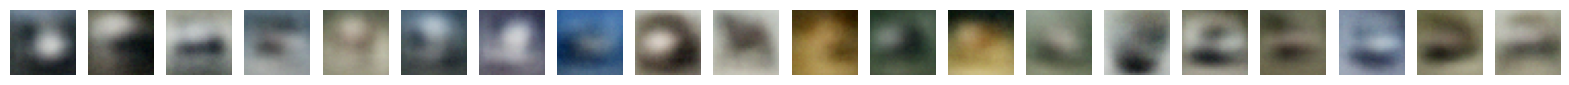

Convolutional VAE - Images


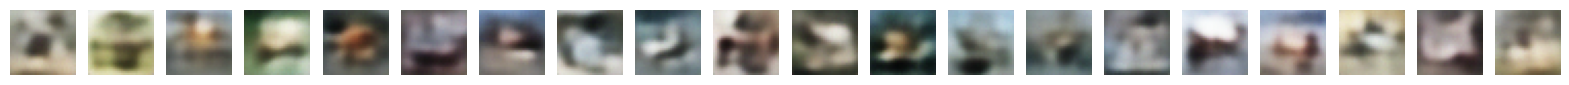

In [31]:
print('Fully Connected VAE - Images')
generate_images(fcvae, 'no', latent_dim=128)

print('Convolutional VAE - Images')
generate_images(cvae, 'yes', latent_dim=128)

In [33]:
def interpolate_images(model, model_name, image1, image2, device, num_steps=20):
    model.eval()
    with torch.no_grad():
        if model_name == 'cvae':
            if image1.shape[1] == 1:
                image1 = image1.repeat(1, 3, 1, 1)
            if image2.shape[1] == 1:
                image2 = image2.repeat(1, 3, 1, 1)
        image1 = image1.to(device)
        image2 = image2.to(device)
        mu1, logvar1 = model.encode(image1)
        mu2, logvar2 = model.encode(image2)
        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)
        interpolated_images = []
        for alpha in np.linspace(0, 1, num_steps):
            interpolated_z = alpha * z2 + (1 - alpha) * z1
            reconstructed_image = model.decode(interpolated_z).cpu()
            if model_name == 'cvae':
                reconstructed_image = (reconstructed_image + 1) / 2
            interpolated_images.append(reconstructed_image)
        interpolated_images = torch.cat(interpolated_images, dim=0)
        return torch.clamp(interpolated_images, 0, 1)

In [34]:
def visualize_interpolation(model, model_name, dataset, num_steps=20):
    data_iter = iter(dataset)
    image1, _ = next(data_iter)
    image2, _ = next(data_iter)
    image1 = image1.unsqueeze(0).to(device)  
    image2 = image2.unsqueeze(0).to(device)  
    
    if image1.shape[1] == 1:
        image1 = image1.repeat(1, 3, 1, 1) 
    if image2.shape[1] == 1:
        image2 = image2.repeat(1, 3, 1, 1) 
    
    interpolated_images = interpolate_images(model, model_name, image1, image2, device, num_steps=num_steps)

    fig, axs = plt.subplots(1, num_steps, figsize=(num_steps, 1))
    for i in range(num_steps):
        image = interpolated_images[i]
        
        if image.shape[-1] == 3072:  
            image = image.view(3, 32, 32)  

        if image.ndimension() == 3 and image.shape[0] == 3: 
            image = image.permute(1, 2, 0) 
        
  
        if image.ndimension() == 2:  
            image = image.cpu().numpy()  
        elif image.ndimension() == 3 and image.shape[2] == 3: 
            image = image.cpu().numpy() 

        axs[i].imshow(image)  
        axs[i].axis('off') 
    plt.show()

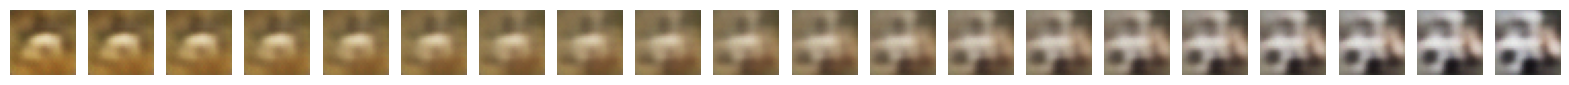

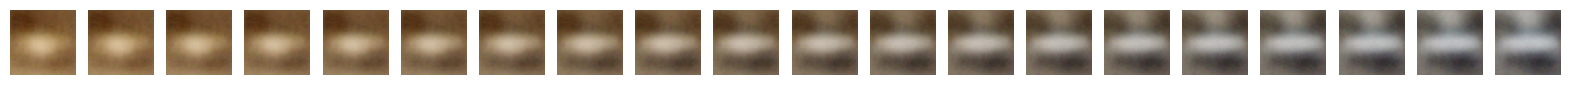

In [36]:
visualize_interpolation(cvae, 'cvae', train_dataset_cvae, num_steps=20)

visualize_interpolation(fcvae, 'fcvae', train_dataset_fcvae, num_steps=20)

Epoch 1: 100%|██████████| 938/938 [00:38<00:00, 24.55batch/s, kld_loss=44.4, recon_loss=364, train_loss=408]  


Epoch 1/20 train loss: 408.2115171875 mse loss: 363.7955386393229 kld loss: 44.41597848409017


Epoch 2: 100%|██████████| 938/938 [00:39<00:00, 23.70batch/s, kld_loss=41.3, recon_loss=138, train_loss=179]    


Epoch 2/20 train loss: 179.21971323242187 mse loss: 137.88521231282553 kld loss: 41.33450067138672


Epoch 3: 100%|██████████| 938/938 [00:54<00:00, 17.21batch/s, kld_loss=38.8, recon_loss=113, train_loss=152]    


Epoch 3/20 train loss: 151.75951914876302 mse loss: 112.94378960367838 kld loss: 38.81572948608398


Epoch 4: 100%|██████████| 938/938 [00:39<00:00, 23.97batch/s, kld_loss=37.9, recon_loss=101, train_loss=139]    


Epoch 4/20 train loss: 138.6998924153646 mse loss: 100.81050597330729 kld loss: 37.88938642171224


Epoch 5: 100%|██████████| 938/938 [00:39<00:00, 23.56batch/s, kld_loss=37.5, recon_loss=93.7, train_loss=131]  


Epoch 5/20 train loss: 131.20384424641927 mse loss: 93.73617209879558 kld loss: 37.467672192382814


Epoch 6: 100%|██████████| 938/938 [00:39<00:00, 23.58batch/s, kld_loss=37.3, recon_loss=88.7, train_loss=126]  


Epoch 6/20 train loss: 125.97301469726563 mse loss: 88.65679753417969 kld loss: 37.31621716308594


Epoch 7: 100%|██████████| 938/938 [00:37<00:00, 24.76batch/s, kld_loss=37.2, recon_loss=85.2, train_loss=122]   


Epoch 7/20 train loss: 122.37274314371744 mse loss: 85.1602631632487 kld loss: 37.21247999267578


Epoch 8: 100%|██████████| 938/938 [01:01<00:00, 15.24batch/s, kld_loss=37.1, recon_loss=82.3, train_loss=119]   


Epoch 8/20 train loss: 119.43159390462239 mse loss: 82.30952331542969 kld loss: 37.1220705851237


Epoch 9: 100%|██████████| 938/938 [00:41<00:00, 22.72batch/s, kld_loss=37.1, recon_loss=80, train_loss=117]    


Epoch 9/20 train loss: 117.03641666666667 mse loss: 79.95929536132813 kld loss: 37.077121366373696


Epoch 10: 100%|██████████| 938/938 [00:42<00:00, 22.24batch/s, kld_loss=37, recon_loss=78.1, train_loss=115]    


Epoch 10/20 train loss: 115.14827816162109 mse loss: 78.13961372884114 kld loss: 37.00866456298828


Epoch 11: 100%|██████████| 938/938 [00:40<00:00, 23.39batch/s, kld_loss=36.9, recon_loss=76.6, train_loss=114]   


Epoch 11/20 train loss: 113.52796147867839 mse loss: 76.59951654052735 kld loss: 36.92844493408203


Epoch 12: 100%|██████████| 938/938 [00:37<00:00, 25.00batch/s, kld_loss=36.8, recon_loss=75.1, train_loss=112]  


Epoch 12/20 train loss: 111.91193737386068 mse loss: 75.06537529296875 kld loss: 36.846562145996096


Epoch 13: 100%|██████████| 938/938 [00:45<00:00, 20.58batch/s, kld_loss=36.8, recon_loss=74, train_loss=111]     


Epoch 13/20 train loss: 110.76382362467447 mse loss: 73.97623990071615 kld loss: 36.78758374226888


Epoch 14: 100%|██████████| 938/938 [00:54<00:00, 17.18batch/s, kld_loss=36.7, recon_loss=73, train_loss=110]     


Epoch 14/20 train loss: 109.75032265218098 mse loss: 73.04008511149088 kld loss: 36.710237471516926


Epoch 15: 100%|██████████| 938/938 [00:41<00:00, 22.46batch/s, kld_loss=36.7, recon_loss=72, train_loss=109]      


Epoch 15/20 train loss: 108.62060118001303 mse loss: 71.95567901611328 kld loss: 36.664922233072915


Epoch 16: 100%|██████████| 938/938 [00:39<00:00, 23.48batch/s, kld_loss=36.6, recon_loss=71.2, train_loss=108]  


Epoch 16/20 train loss: 107.86105319010417 mse loss: 71.2392576924642 kld loss: 36.621795515950524


Epoch 17: 100%|██████████| 938/938 [00:38<00:00, 24.17batch/s, kld_loss=36.6, recon_loss=70.6, train_loss=107]   


Epoch 17/20 train loss: 107.14128863118489 mse loss: 70.5627757039388 kld loss: 36.57851284790039


Epoch 18: 100%|██████████| 938/938 [00:38<00:00, 24.59batch/s, kld_loss=36.5, recon_loss=69.9, train_loss=106]   


Epoch 18/20 train loss: 106.42130331217447 mse loss: 69.90459688517252 kld loss: 36.51670642089844


Epoch 19: 100%|██████████| 938/938 [00:38<00:00, 24.38batch/s, kld_loss=36.4, recon_loss=69.3, train_loss=106]  


Epoch 19/20 train loss: 105.73777732340494 mse loss: 69.33719192301432 kld loss: 36.400585306803386


Epoch 20: 100%|██████████| 938/938 [00:38<00:00, 24.12batch/s, kld_loss=36.4, recon_loss=68.8, train_loss=105]   


Epoch 20/20 train loss: 105.19144742838542 mse loss: 68.7959564493815 kld loss: 36.39549095662435
FashionMNIST VAE - Generated Images


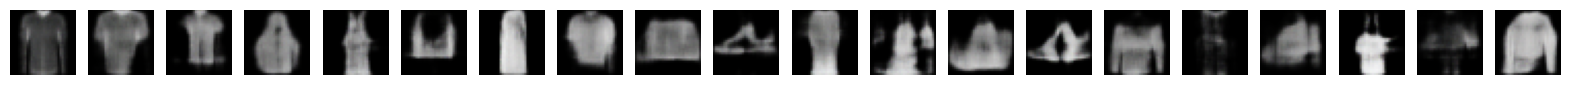

In [48]:
# Import FashionMNIST Dataset
from torchvision import datasets, transforms

# Modify the transformation for FashionMNIST (28x28 grayscale images)
transform_fashionmnist = transforms.Compose([
    transforms.Resize(32),  # Resize to match the expected input size (32x32)
    transforms.Grayscale(3),  # Convert grayscale to 3 channels (RGB)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load FashionMNIST dataset
train_dataset_fashionmnist = datasets.FashionMNIST('./data2', train=True, download=True, transform=transform_fashionmnist)
train_loader_fashionmnist = torch.utils.data.DataLoader(train_dataset_fashionmnist, batch_size=64, shuffle=True)

# Use the same model (ConvVAE or FCVAE) as before
fashionmnist_vae = ConvVAE(latent_dim=128).to(device)  # Or use FCVAE
optimizer_fashionmnist_vae = optim.Adam(fashionmnist_vae.parameters(), lr=lr)

# Train the VAE on FashionMNIST
for epoch in range(1, num_epochs + 1):
    train(fashionmnist_vae, train_loader_fashionmnist, optimizer_fashionmnist_vae, epoch, num_epochs, 'cvae', device)

# Generate Images from FashionMNIST VAE
print('FashionMNIST VAE - Generated Images')
generate_images(fashionmnist_vae, 'yes', latent_dim=128)


Epoch 1: 100%|██████████| 938/938 [00:22<00:00, 42.48batch/s, kld_loss=36.5, recon_loss=251, train_loss=287]  


Epoch 1/20 train loss: 287.21353898111977 mse loss: 250.67756834309895 kld loss: 36.5359709370931


Epoch 2: 100%|██████████| 938/938 [00:22<00:00, 41.43batch/s, kld_loss=31.1, recon_loss=138, train_loss=169]   


Epoch 2/20 train loss: 169.32048413085937 mse loss: 138.25551170247397 kld loss: 31.064972607421875


Epoch 3: 100%|██████████| 938/938 [00:22<00:00, 41.78batch/s, kld_loss=30, recon_loss=118, train_loss=148]     


Epoch 3/20 train loss: 147.9275203938802 mse loss: 117.89574223632812 kld loss: 30.031778239949546


Epoch 4: 100%|██████████| 938/938 [00:22<00:00, 41.35batch/s, kld_loss=30, recon_loss=108, train_loss=138]      


Epoch 4/20 train loss: 138.18413935546874 mse loss: 108.22554957682291 kld loss: 29.958589827473958


Epoch 5: 100%|██████████| 938/938 [00:23<00:00, 40.11batch/s, kld_loss=30.1, recon_loss=102, train_loss=132]    


Epoch 5/20 train loss: 132.30516626383462 mse loss: 102.23263739013672 kld loss: 30.072528744506837


Epoch 6: 100%|██████████| 938/938 [00:22<00:00, 42.03batch/s, kld_loss=30.2, recon_loss=97.9, train_loss=128]   


Epoch 6/20 train loss: 128.09505778808594 mse loss: 97.86047400716146 kld loss: 30.23458360595703


Epoch 7: 100%|██████████| 938/938 [00:23<00:00, 40.67batch/s, kld_loss=30.4, recon_loss=94.6, train_loss=125]   


Epoch 7/20 train loss: 124.98033363850911 mse loss: 94.58891025390625 kld loss: 30.391423467000326


Epoch 8: 100%|██████████| 938/938 [00:22<00:00, 41.16batch/s, kld_loss=30.5, recon_loss=91.4, train_loss=122]   


Epoch 8/20 train loss: 121.91946897379557 mse loss: 91.39849527180989 kld loss: 30.520973717244466


Epoch 9: 100%|██████████| 938/938 [00:22<00:00, 42.32batch/s, kld_loss=30.6, recon_loss=89.1, train_loss=120]  


Epoch 9/20 train loss: 119.65223610839844 mse loss: 89.07308084309896 kld loss: 30.579155385335287


Epoch 10: 100%|██████████| 938/938 [00:23<00:00, 39.14batch/s, kld_loss=30.6, recon_loss=87, train_loss=118]     


Epoch 10/20 train loss: 117.65530203450521 mse loss: 87.00657993164063 kld loss: 30.64872211405436


Epoch 11: 100%|██████████| 938/938 [00:21<00:00, 42.83batch/s, kld_loss=30.7, recon_loss=85.2, train_loss=116]  


Epoch 11/20 train loss: 115.95800784505208 mse loss: 85.22983157958984 kld loss: 30.728176204427083


Epoch 12: 100%|██████████| 938/938 [00:23<00:00, 40.66batch/s, kld_loss=30.7, recon_loss=83.6, train_loss=114]   


Epoch 12/20 train loss: 114.3357350016276 mse loss: 83.59013019205729 kld loss: 30.745604821777345


Epoch 13: 100%|██████████| 938/938 [00:22<00:00, 42.51batch/s, kld_loss=30.8, recon_loss=82.3, train_loss=113]   


Epoch 13/20 train loss: 113.09213794352213 mse loss: 82.2772051920573 kld loss: 30.814932752482097


Epoch 14: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, kld_loss=30.9, recon_loss=81, train_loss=112]     


Epoch 14/20 train loss: 111.89987167154948 mse loss: 81.018534765625 kld loss: 30.881336735026043


Epoch 15: 100%|██████████| 938/938 [00:22<00:00, 40.86batch/s, kld_loss=30.9, recon_loss=79.9, train_loss=111]  


Epoch 15/20 train loss: 110.79288416341146 mse loss: 79.90705920410156 kld loss: 30.885824965413413


Epoch 16: 100%|██████████| 938/938 [00:22<00:00, 42.49batch/s, kld_loss=30.9, recon_loss=79, train_loss=110]     


Epoch 16/20 train loss: 109.8962459798177 mse loss: 78.98669654947916 kld loss: 30.909549525960287


Epoch 17: 100%|██████████| 938/938 [00:22<00:00, 42.48batch/s, kld_loss=30.9, recon_loss=78, train_loss=109]     


Epoch 17/20 train loss: 108.95987869873046 mse loss: 78.01267532958984 kld loss: 30.9472032236735


Epoch 18: 100%|██████████| 938/938 [00:22<00:00, 41.80batch/s, kld_loss=31, recon_loss=77.2, train_loss=108]     


Epoch 18/20 train loss: 108.19285813802084 mse loss: 77.21646630045574 kld loss: 30.97639176940918


Epoch 19: 100%|██████████| 938/938 [00:21<00:00, 42.77batch/s, kld_loss=31, recon_loss=76.4, train_loss=107]    


Epoch 19/20 train loss: 107.38926624348959 mse loss: 76.39061888427734 kld loss: 30.998647295125327


Epoch 20: 100%|██████████| 938/938 [00:22<00:00, 42.38batch/s, kld_loss=31, recon_loss=75.9, train_loss=107]     


Epoch 20/20 train loss: 106.86997453206381 mse loss: 75.87354380696614 kld loss: 30.996430604044598
FashionMNIST FCVAE - Generated Images


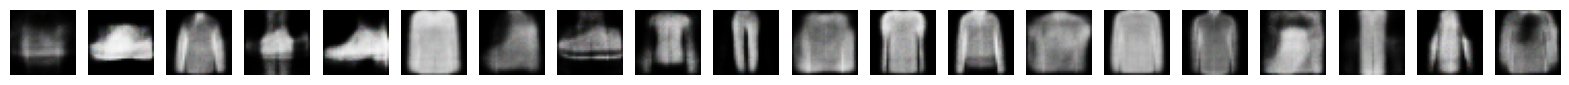

In [51]:
# Use the same model (FCVAE) as before
fashionmnist_fcvae = FCVAE(input_dim=3072, hidden_dim=1000, latent_dim=128).to(device)
optimizer_fashionmnist_fcvae = optim.Adam(fashionmnist_fcvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(fashionmnist_fcvae, train_loader_fashionmnist, optimizer_fashionmnist_fcvae, epoch, num_epochs, 'fcvae', device)


# Generate Images from FashionMNIST VAE
print('FashionMNIST FCVAE - Generated Images')
generate_images(fashionmnist_fcvae, 'yes', latent_dim=128)


FashionMNIST VAE - Interpolation


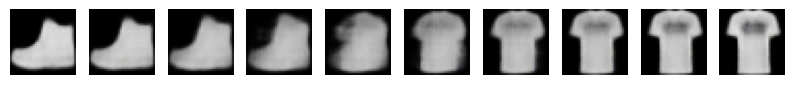

FashionMNIST FCVAE - Interpolation


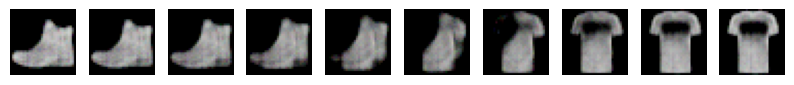

In [52]:
# Visualize interpolation for FashionMNIST VAE
print('FashionMNIST VAE - Interpolation')
visualize_interpolation(fashionmnist_vae, 'cvae', train_dataset_fashionmnist, num_steps=10)

print('FashionMNIST FCVAE - Interpolation')
visualize_interpolation(fashionmnist_fcvae, 'fcvae', train_dataset_fashionmnist, num_steps=10)